In [2]:
import pandas as pd 
import numpy as np 
import cv2 
import os 
from random import choice 
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
labels = pd.read_csv('labels.csv')
labels.head(2)

,xmin,xmax,ymin,ymax,Frame,Label,Preview URL
0,785,533,905,644,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
1,89,551,291,680,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...


In [4]:
images = labels.Frame.unique()
print ('{} unique images'.format(images.shape[0]))
print ('{} labels'.format(labels.shape[0]))
print ('{} cars'.format(labels[labels.Label == 'Car'].shape[0]))
print ('{} trucks'.format(labels[labels.Label == 'Truck'].shape[0]))
print ('{} pedestrians'.format(labels[labels.Label == 'Pedestrian'].shape[0]))

9218 unique images
72064 labels
62570 cars
3819 trucks
5675 pedestrians


We are only identifying vehicles here, so drop all pedestrians. 

In [5]:
labels = labels[labels.Label != 'Pedestrian']

View some images and labels, Create Masks

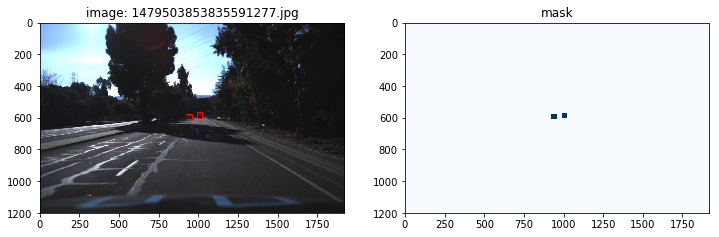

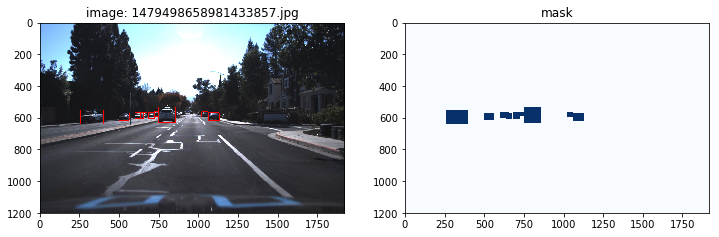

In [6]:
def show_img(id_):
    IDs = labels[labels.Frame == id_] #all IDs in that photo 
    
    im_path = os.path.join('..', 'crowdai', id_)
    img = cv2.imread(im_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mask = np.zeros(shape=img.shape[:2])
    
    for i in range(IDs.shape[0]):
        vehicle_ID = IDs.iloc[i]
         
        if vehicle_ID.Label == 'Car': 
            color = (255, 0, 0)
            mask_color = 1
        if vehicle_ID.Label == 'Truck': 
            color = (0, 255, 0)
            mask_color = 2
        
        mask[vehicle_ID.xmax:vehicle_ID.ymax,
             vehicle_ID.xmin:vehicle_ID.ymin ] = mask_color
        
        cv2.rectangle(img,
                      (vehicle_ID.xmin, vehicle_ID.xmax),
                      (vehicle_ID.ymin, vehicle_ID.ymax),
                      color,  3, 5)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1); plt.title('image: ' + id_)
    plt.imshow(img)
    
    plt.subplot(1, 2, 2); plt.title('mask')
    plt.imshow(mask, cmap='Blues')
    plt.show()
    
for i in range(2): 
    show_img(choice(images))

Cool. Looks like we can create the masks pretty easily. I will now turn this into a Python generator, add some image augmentation functions, and have this be the input to the neural network. 

see [generator.py file](generator.py)

Additionally, we can get a baseline for the IOU, by seeing how much, on average, a car mask covers the image. For example, if 20% of the pixels in the image are covered by the car mask, then an IOU of 0.20 would be the baseline, since randomly sampling pixels from the frame would yield this IOU value. 

In [7]:
def get_area(x):
    area = (x.ymax - x.xmax) * (x.ymin - x.xmin)
    return area 

labels['area'] = labels.apply(get_area, axis=1)

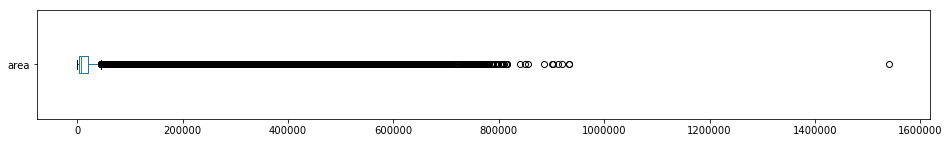

In [24]:
plt.figure(figsize=(16, 2))
labels.area.plot.box(vert=False)

In [34]:
img_area = 1900*1200

total_mask_areas = []
for img in labels.Frame.unique(): 
    single_img = labels[labels['Frame'] == img]
    total_mask_areas.append(single_img['area'].sum() / img_area)

mean: 0.09862581448872944 max: 0.6830372807017544 min: 0.0


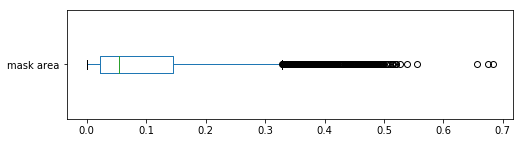

In [69]:
masks = pd.Series(total_mask_areas, name='mask area')

print ('mean: {} max: {} min: {}'.format(masks.mean(), masks.max(), masks.min()))
plt.figure(figsize=(16, 2))
masks.plot.box(vert=False);

So about .10 is the nubmer to beat. 